In [1]:
# Importing neccessary packages.

import os
import time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore the warning.
import warnings
warnings.filterwarnings('ignore')
#------------------------------------------
notebook_start_time = time.time()

C:\Users\A.Sharma26\AppData\Local\Temp\ipykernel_28232\2777837353.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
batch_size = 32
img_height = 128
img_width = 128
# Setting up image data generators for training and validation.
# The generators apply a rescale transformation to the images and fill any gaps using the 'reflect' method.

img_train_path = "./DATASET/TRAIN"
img_test_path = "./DATASET/TEST"
data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
val_gen = ImageDataGenerator(rescale=1./255)

train_gen = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=128)
validation_gen = val_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=128)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [3]:
print("Train/Validation indicies: ", train_gen.class_indices)
print("\n0 Stands for Organic \"O\", and 1 stands for Non-Organic \"R\"")

Train/Validation indicies:  {'O': 0, 'R': 1}

0 Stands for Organic "O", and 1 stands for Non-Organic "R"


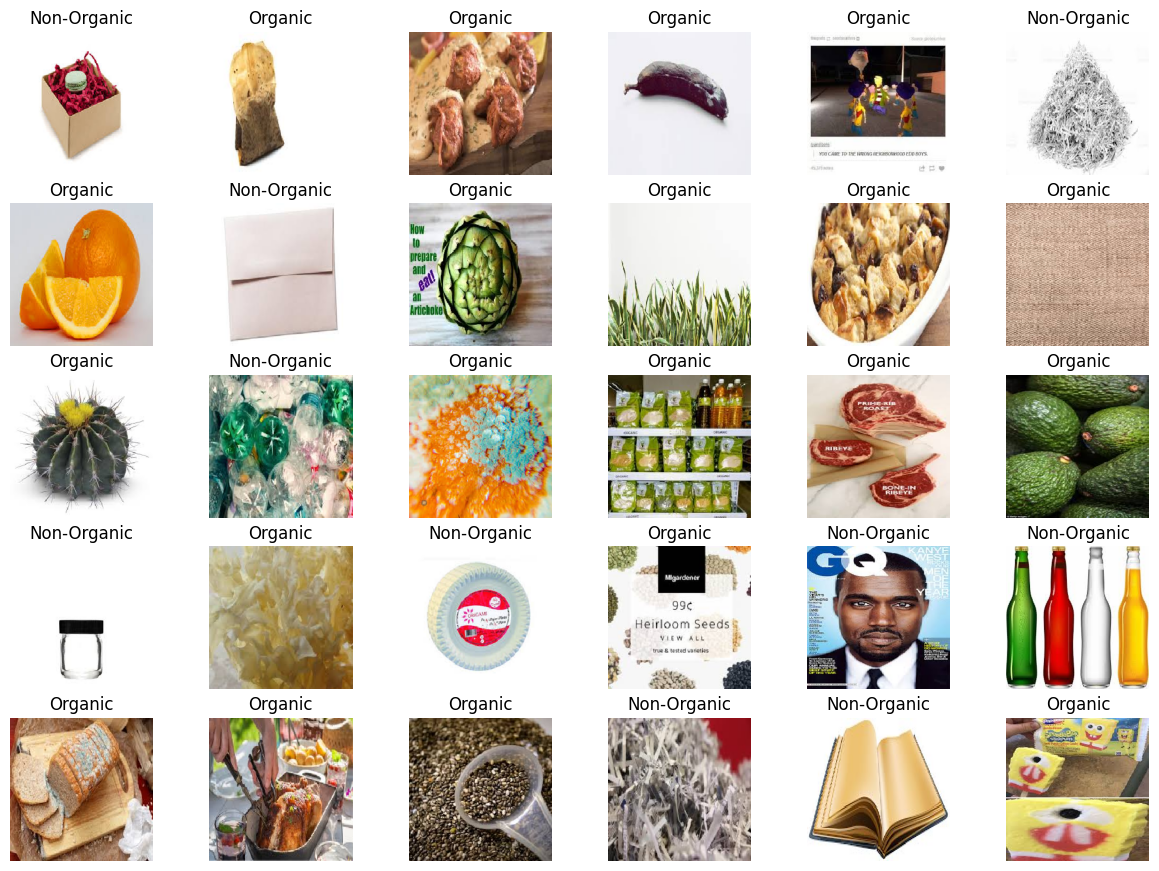

In [4]:
# Plotting images from the train set.

img, _= next(train_gen)
plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if _[i][1] == 0:
        plt.title("Organic")
    else:
        plt.title("Non-Organic")
    plt.axis("off")
del img
del _ 

In [5]:


model = tf.keras.Sequential()

# Add convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add fully-connected layers with weight decay
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)      

In [6]:
model.compile(optimizer='Nadam',loss='CategoricalCrossentropy', metrics=['accuracy'])

In [7]:
# Setting up early stopping and model checkpointing to ensure we save the best model during training
# The early stopping monitor will stop training if the validation loss does not improve after 5 epochs
# The model checkpoint will save the best model based on the validation loss, and restore the best weights if training is stopped early

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', save_best_only=True)

In [9]:
# Compiling the model using the Nadam optimizer, categorical cross-entropy loss, and accuracy metric

history = model.fit(train_gen, validation_data=validation_gen, epochs=10, callbacks=[best_model, early_stopping_monitor])

Epoch 1/10
  9/177 [>.............................] - ETA: 24:59 - loss: 1.3076 - accuracy: 0.5365

ResourceExhaustedError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
MemoryError: Unable to allocate 96.0 MiB for an array with shape (128, 256, 256, 3) and data type float32
Traceback (most recent call last):

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\data_adapter.py", line 918, in wrapped_generator
    yield self._standardize_batch(data)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\data_adapter.py", line 944, in _standardize_batch
    data = tf.nest.map_structure(_convert_dtype, data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest.py", line 631, in map_structure
    return nest_util.map_structure(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1066, in map_structure
    return _tf_core_map_structure(func, *structure, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1106, in _tf_core_map_structure
    [func(*x) for x in entries],
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1106, in <listcomp>
    [func(*x) for x in entries],
     ^^^^^^^^

  File "C:\Users\A.Sharma26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\data_adapter.py", line 941, in _convert_dtype
    return np.array(t, dtype=backend.floatx())
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 96.0 MiB for an array with shape (128, 256, 256, 3) and data type float32


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3265]

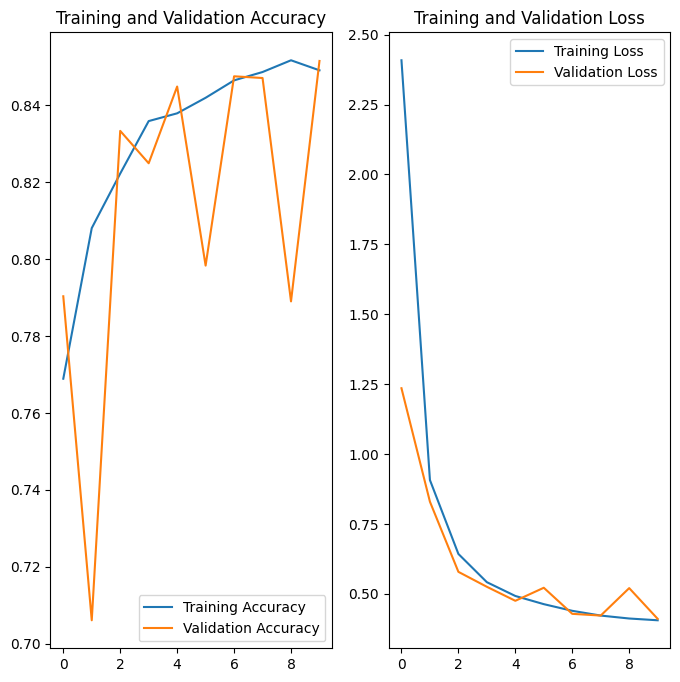

In [16]:
epochs = 10

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
print("Fit model on training data")

print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Fit model on training data
Evaluate on test data
79/79 [==============================] - 12s 133ms/step - loss: 0.3440 - accuracy: 0.8926
test loss, test acc: [0.34401580691337585, 0.8925586938858032]
